# Mestrado Prossional de Economia INSPER - Turma MPE16
# Trabalho de conclusão do curso de Finanças Quantitativas (2020.1)

#### Autores: Ciro Aloísio de Paula Duarte, João Italo Zecchin Reis, Robert Aldo Andreotti Filho 


#### O relatório do trabalho está separado em dois arquivos de Jupyter Notebook:
    Parte 1: Desenvolvimento dos trackers e dos sinais de momentum, value e carry das moedas analisadas contra o dólar americano.
    Parte 2: Criação da estratégia de trading e realização do backtest.

##    
## PARTE 2 
##   

## Introdução

O objetivo do trabalho é criarmos uma estratégia de pair trading entre moedas de um mesmo bloco econômico que faça sentido a comparação entre elas duas a duas. 

A proposta deste segundo jupyter notebook é desenvolvermos uma estratégia de trading baseado nos sinais de momentum, value e carry produzidos pela parte 1 do trabalho. Para tal, elaboramos uma regressão logística e um modelo de classificação KNN que indica de forma binária se o retorno do ativo será positivo ou negativo e em seguida, considerando o KNN, calculamos a probabilidade de termos no futuro um mercado positivo. 

Por fim, com os sinais criados pelo modelo realizamos um backtest para o resto do período.

Vale ressaltar que como fonte de dados usamos sempre informações extraídas da Bloomberg.

In [1]:
#import das bibliotecas
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from bloomberg import BBG
bbg = BBG()

###   
#### Definição das moedas usadas na estratégia
Para executarmos nossa estratégia de trading decidimos separar as moedas em três grupos, cada qual com uma característica econômica para então fazermos o pair trading entre todas as moedas de uma mesma cesta:

No projeto separamos três blocos:

    - Moedas de países da Europa (EUR, GBP e SEK); 
    - Moedas de países relevantes em commodities (AUD, CAD, NOK e ZND);
    - Moedas de países emergentes e Latam (BRL e MXN);

In [12]:
#inicialização das listas dos blocos para evitar que em novas execuções do código possa ter lixo na memória
europe = []
cmdty = []
latam = []

#definição dos blocos de moedas em listas
europe = ['EUR', 'GBP', 'SEK']
cmdty = ['AUD', 'CAD', 'NOK', 'NZD']
latam = ['BRL', 'MXN', 'CLP']

basket = [europe, cmdty, latam]
basket_names = ['europe', 'cmdty', 'latam']

#### Leitura dos trackers e dos sinais desenvolvidos na parte 1 do projeto paro uso neste Jupyter Notebook


In [13]:
#Todos os arquivos em excel devem na mesma pasta que este jupyter notebook
mom_df = pd.read_excel('momentum.xlsx',index_col=0)
value_df = pd.read_excel('value.xlsx',index_col=0)
carry_df = pd.read_excel('carry.xlsx',index_col=0)
trackers_df = pd.read_excel('trackers.xlsx',index_col=0)


#### Criação dos sinais com os retornos das moedas ao longo do tempo

In [14]:
#consideramos o retornos mensais, aproximadamente 21 dias úteis
h = 21 
#Note que o uso do método .shift(-h) no datframe garante que teremos no index t o retorno de t até t+h
returns_df = trackers_df.pct_change(h).shift(-h).dropna()

##    
## Estratégia

Nesta sessão desenvolvemos dois modelos de classificação baseadas nos sinais de entrada momentum, carry e value.

Implementamos a regressão logística, mais básica e mais popularmente conhecida, e a K-Neartest Neighbors (KNN), mais robusta, que consiste em um modelo que identifica as K observaões passadas mais próximas a atual e classifica a uma classe mais próvável de acordo com a regra de Bayes. Para ambas, o resultado é binário indicando se o retorno esperado é positivo ou negativo.

Posto isso, usamos nossos modelos para prever a probabilidade do preço do par de moedas subir e dependendo desse resultado, decidmos comprar, vender ou manter o par de moedas em nosso book.

Como o KNN obeteve os melhores resultads, conforme esperado, usamos ele como modelo base da estratégia, por isso ao final do código, retornamos um dataframe que será usado no bacteste contendo o sinal da probabilidade do mercado subir para cada um dos da nossa cesta ativos.

In [15]:
import statsmodels.api as sm
signal = pd.DataFrame()
signal_knn = pd.DataFrame()

n = 5
for ccy in trackers_df.columns:
    print('Running currency %s' % ccy, end="\r")
    y = (1*(returns_df[ccy]>=0)).to_frame('returns')
    
    #padronização dos sinais
    X_carry = carry_df[ccy].dropna().to_frame('carry')
    X_mom = mom_df[ccy].dropna().to_frame('mom')
    X_value = value_df[ccy].dropna().to_frame('value')
    
    #garante alnhamento dos sinais e preencha as nan's com a última observação, caso haja alguma
    X = pd.concat([X_carry,X_mom,X_value],join='outer',axis=1,sort=True).fillna(method='ffill').dropna()
    X = sm.add_constant(X)
    
    #garante padronização das datas dos sinais e dos retornos futuros
    yX = pd.concat([y,X],axis=1,sort=True).dropna()
    
    X_with_interactions = PolynomialFeatures(interaction_only=True)
    X_with_interactions.fit_transform(X)
    features = X_with_interactions.get_feature_names(X.columns)
    features[0] = 'const'
    X_with_interactions = X_with_interactions.fit_transform(X)
    X_with_interactions = pd.DataFrame(index=X.index,data=X_with_interactions,columns=features).drop('const',1)
    yX_knn = pd.concat([y,X_with_interactions.shift(1).dropna()],axis=1,sort=True).dropna()
    
    neigh = KNeighborsClassifier(n_neighbors=n)    
    prob_market_going_up = pd.Series(index=yX.index[3*252:])
    prob_market_going_up_knn = pd.DataFrame()
    
    #loop ao longo dos dias
    for d in prob_market_going_up.index:

        #adquiri os dados do passado para o cálculo do sinal
        past_returns_indicator = yX.iloc[:,0].loc[:d]
        past_features = yX.iloc[:,1:].loc[:d]
        past_returns_indicator_knn = yX_knn.iloc[:,0].loc[:d]
        past_features_knn = yX_knn.iloc[:,1:].loc[:d]
        
        #ajusta o modelo usando o Logit, mas não usa as últimas h observações para garantir que estamos usando o conjunto de informações correto
        model = sm.Logit(past_returns_indicator.shift(h).dropna(), past_features.shift(h).dropna()).fit(disp=False)
        neigh.fit(past_features_knn, past_returns_indicator_knn)
        

        #usando as informações atuais para predizer o mercado
        current_features = past_features.ewm(halflife=63).mean().iloc[-1] # note here the EWMA smoothing here
        current_features_knn = X_with_interactions.loc[:d].iloc[-1].values
        prob_market_going_up[d]= model.predict([current_features])[0]
        prob_market_going_up_knn[d] = neigh.predict_proba([current_features_knn])[0]
    
    signal = pd.concat([signal,prob_market_going_up.to_frame(ccy)],join='outer',axis=1,sort=True)
    signal_knn = pd.concat([signal_knn,prob_market_going_up_knn.iloc[1,:].to_frame(ccy)],join='outer',axis=1,sort=True)

signal = signal.fillna(method='ffill')

###   
Visualização gráfica da probabilidade de alta do mercado de FX ao londo do tempo para cada um dos pares de moeda. Nota-se que, seguindo o modelo do KNN, que recorrentemente acreditamos que a melhor recomendação é a compra do MXN frente ao dólar.

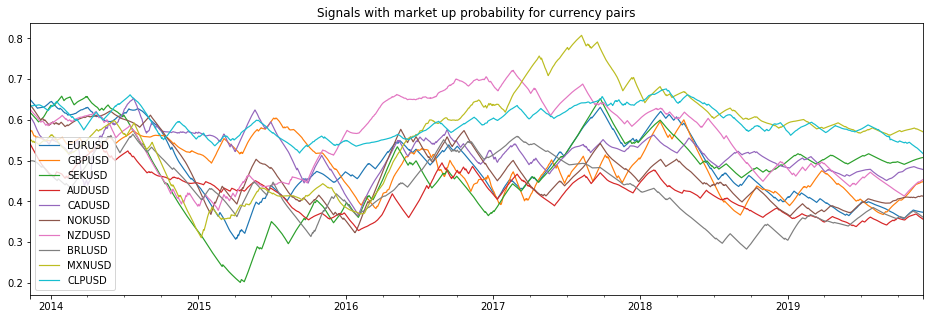

In [16]:
signal.plot(title='Signals with market up probability for currency pairs',figsize=(16,5), linewidth=1.2)
plt.show()

##   
## Backtest

In [17]:
#combinação dos pares entre si
pairs = []
for group in basket:
    pair_combiantions = list(itertools.combinations(group, 2))
    for i in range(len(pair_combiantions)):
        ccy1, ccy2 = pair_combiantions[i]
        pairs.append(ccy1+ccy2)

In [18]:
def backtest_by_group(group, trackers_df, signal, pairs):  
    
    trackers_df = trackers_df.fillna(method='ffill')
    backtest = pd.DataFrame(index=signal.index, columns = pairs)

    pair_combiantions = list(itertools.combinations(group, 2))
    for i in range(len(pair_combiantions)):
        ccy1, ccy2 = pair_combiantions[i]

        pair1 = ccy1+'USD'
        pair2 = ccy2+'USD'

        backtest[ccy1+ccy2].iloc[0] = 100 # initialize the backtest with 100
        start_date = signal.index[0]

        # first trade
        vols_ccy1 = np.log(trackers_df[pair1].loc[:start_date]).diff(1).ewm(halflife=60).std()*np.sqrt(252)
        vols_ccy2 = np.log(trackers_df[pair2].loc[:start_date]).diff(1).ewm(halflife=60).std()*np.sqrt(252)
        positions_ccy1 = 1*(signal[pair1].iloc[0] - signal[pair2].iloc[0]>0.05) + -1*(signal[pair2].iloc[0] - signal[pair1].iloc[0]>0.05)
        positions_ccy2 = -1*positions_ccy1
        prices_ccy1 = trackers_df[pair1].loc[:start_date].iloc[-1]
        prices_ccy2 = trackers_df[pair2].loc[:start_date].iloc[-1]
        holdings_ccy1 = ((0.4/vols_ccy1.iloc[-2])*positions_ccy1)*(backtest[ccy1+ccy2].iloc[0]/prices_ccy1)
        holdings_ccy2 = ((0.4/vols_ccy2.iloc[-2])*positions_ccy2)*(backtest[ccy1+ccy2].iloc[0]/prices_ccy2)
        if positions_ccy1 == -1:
            holdings_ccy2 = holdings_ccy1
        else:
            holdings_ccy1 = holdings_ccy2

        print('Running currency ' + ccy1 + ccy2, end="\r")

        # loop over the next days
        for i in range(1,len(signal)): # loop over all the signals
            tdy = signal[pair1].index[i]
            yst = signal[pair1].index[i-1]

            # calculate pnl on the day
            price_change_ccy1 = trackers_df[pair1].loc[:tdy].iloc[-1] - trackers_df[pair1].loc[:yst].iloc[-1]
            price_change_ccy2 = trackers_df[pair2].loc[:tdy].iloc[-1] - trackers_df[pair2].loc[:yst].iloc[-1]
            pnl_ccy1 = (holdings_ccy1*price_change_ccy1).mean()
            pnl_ccy2 = (holdings_ccy2*price_change_ccy2).mean()
            backtest[ccy1+ccy2].iloc[i] = backtest[ccy1+ccy2].iloc[i-1] + pnl_ccy1 + pnl_ccy2

            if tdy.week != yst.week: # check if it's a new week and reasses trades if so        
                vols_ccy1 = np.log(trackers_df[pair1].loc[:tdy]).diff(1).ewm(halflife=60).std()*np.sqrt(252)
                vols_ccy2 = np.log(trackers_df[pair2].loc[:tdy]).diff(1).ewm(halflife=60).std()*np.sqrt(252)
                positions_ccy1 = 1*(-signal[pair1].iloc[i] + signal[pair2].iloc[i]>0.05) + -1*(-signal[pair2].iloc[i] + signal[pair1].iloc[i]>0.05)
                positions_ccy2 = -1*positions_ccy1
                prices_ccy1 = trackers_df[pair1].loc[:tdy].iloc[-1]
                prices_ccy2 = trackers_df[pair2].loc[:tdy].iloc[-1]
                holdings_ccy1 = ((0.4/vols_ccy1.iloc[-2])*positions_ccy1)*(backtest[ccy1+ccy2].iloc[i]/prices_ccy1)
                holdings_ccy2 = ((0.4/vols_ccy2.iloc[-2])*positions_ccy2)*(backtest[ccy1+ccy2].iloc[i]/prices_ccy2)
                if positions_ccy1 == -1:
                    holdings_ccy2 = holdings_ccy1
                else:
                    holdings_ccy1 = holdings_ccy2

    return backtest


In [19]:
def avg_backtest(backtest, pairs, col_name):    
    backtest[col_name] = 0
    for pair in pairs:
        backtest[col_name] = backtest[col_name] + backtest[pair]
    backtest[col_name] = backtest[col_name]/len(pairs)
    return backtest[col_name]

#### Simulações de backtest separados por bloco econômico e também por a comparação entre si
* Europa: destaques ...
* Cmdty: destaque ....
* Latam: destaque .... 
* Todos os blocos: ....


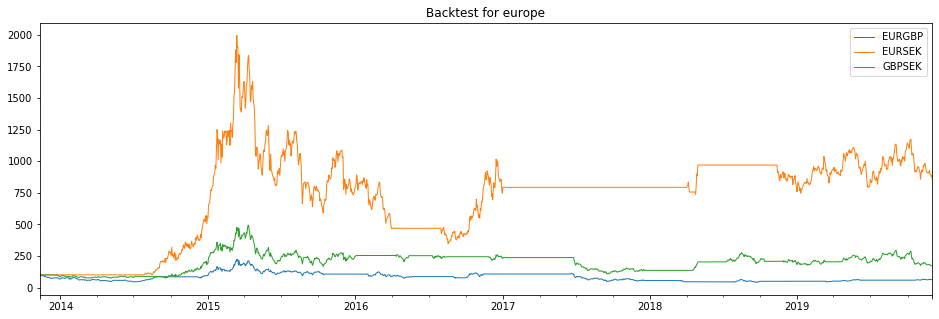

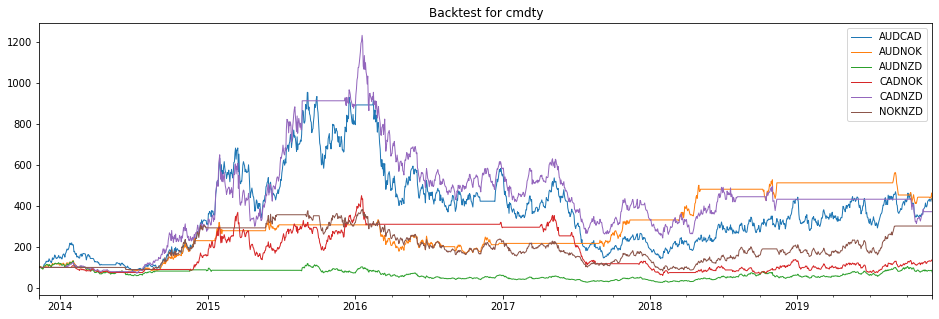

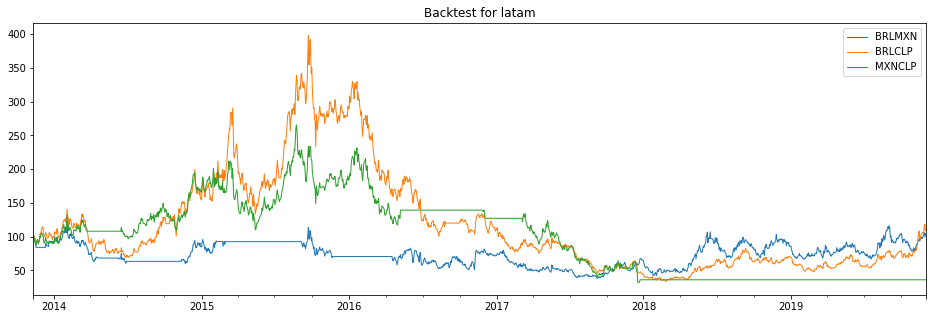

In [20]:
#inicializações
backtest_tot = pd.DataFrame()
group_num = -1

#loop com backtest de cada bloco econômico em separado
for group in basket:
   
    pairs = []
    group_num = group_num + 1
    backtest_group = pd.DataFrame()
    pair_combiantions = list(itertools.combinations(group, 2))
    for i in range(len(pair_combiantions)):
        ccy1, ccy2 = pair_combiantions[i]
        pairs.append(ccy1+ccy2)    
    
    backtest_group = backtest_by_group(group, trackers_df, signal, pairs)
    backtest_group.plot(title='Backtest for ' + basket_names[group_num],figsize=(16,5), linewidth=1)
    plt.show()
    backtest_tot = backtest_tot.append(avg_backtest(backtest_group, pairs, basket_names[group_num]))

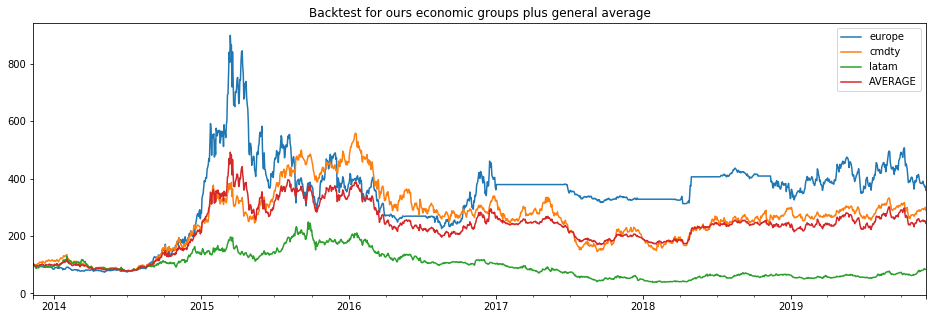

In [24]:
backtest_tot_groups = backtest_tot.T
backtest_tot_groups.append(avg_backtest(backtest_tot_groups, basket_names, "AVERAGE"))
backtest_tot_groups.plot(title='Backtest for ours economic groups plus general average',figsize=(16,5), linewidth=1.5)
plt.show()

.....   

.....

.....

In [23]:
matriz_final = pd.DataFrame(columns = ['Currency', 'Count', 'Criteria', 'Method'])
for ccy in trackers_df.columns:

    y = 1*(np.sign(returns_df[[ccy]])>=0)
    prediction = 1*(np.sign(signal[[ccy]] - 0.5)>0)
    prediction_knn = 1*(np.sign(signal_knn[[ccy]] - 0.5)>0)
    
    matriz = pd.concat([prediction,y],join='inner',axis=1,sort=True)
    matriz_final = matriz_final.append({'Currency': ccy,
                                        'Count': confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(1,1),
                                        'Criteria': 'TP',
                                        'Method': 'Logistic'}, ignore_index=True)
    matriz_final = matriz_final.append({'Currency': ccy,
                                        'Count': confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(0,0),
                                        'Criteria': 'TN',
                                        'Method': 'Logistic'}, ignore_index=True)
    matriz_final = matriz_final.append({'Currency': ccy,
                                        'Count': confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(0,1),
                                        'Criteria': 'FP',
                                        'Method': 'Logistic'}, ignore_index=True)
    matriz_final = matriz_final.append({'Currency': ccy,
                                        'Count': confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(1,0),
                                        'Criteria': 'FN',
                                        'Method': 'Logistic'}, ignore_index=True)

    matriz = pd.concat([prediction_knn,y],join='inner',axis=1,sort=True)
    matriz_final = matriz_final.append({'Currency': ccy,
                                        'Count': confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(1,1),
                                        'Criteria': 'TP',
                                        'Method': 'KNN'}, ignore_index=True)
    matriz_final = matriz_final.append({'Currency': ccy,
                                        'Count': confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(0,0),
                                        'Criteria': 'TN',
                                        'Method': 'KNN'}, ignore_index=True)
    matriz_final = matriz_final.append({'Currency': ccy,
                                        'Count': confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(0,1),
                                        'Criteria': 'FP',
                                        'Method': 'KNN'}, ignore_index=True)
    matriz_final = matriz_final.append({'Currency': ccy,
                                        'Count': confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(1,0),
                                        'Criteria': 'FN',
                                        'Method': 'KNN'}, ignore_index=True)
table = pd.pivot_table(matriz_final, values=['Count'], index=['Currency'],
                    columns=['Method', 'Criteria'], aggfunc=np.sum)
table

Count                                       
Method     KNN                Logistic               
Criteria    FN   FP   TN   TP       FN   FP   TN   TP
Currency                                             
AUDUSD     362  289  572  358       66  599  868   48
BRLUSD     261  270  641  409      213  523  689  156
CADUSD     423  241  427  490      661  326  189  405
CLPUSD     333  238  417  593      750    0    0  831
EURUSD     332  286  610  353      414  380  528  259
GBPUSD     359  283  499  440      428  434  430  289
MXNUSD     341  272  492  476      560  140  273  608
NOKUSD     378  266  539  398      326  488  591  176
NZDUSD     383  288  483  427      501  245  365  470
SEKUSD     310  298  510  463      367  495  453  266